In [ ]:
# This is the basic proportional rate diffusion model from Palmer, Huk and Shadlen '05. 
# In this version, I'm trying to fit conditions in which both coherence and distance 
# are non-zero (i.e. exclude C0Dall and D0Call). 

# In Python, when you flatten a 2D matrix, it is read row-wise. So first row is read first, 
# then second row etc. This means that I need to exclude indices 0:5, 10 and 15.

In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from math import factorial as fact

In [2]:
# List subjects to fit
subs = ['Sub01', 'Sub02', 'Sub04', 'Sub05', 'Sub06', 'Sub08', 'Sub10', 'Sub11', 'Sub13']
nSub = len(subs)

# Indices to remove: 0, 5, 10, 15
keepId = np.setdiff1d(range(20), np.append(range(6), [10, 15]))
nCD = len(keepId)

# Initialize arrays to hold PC, mean and SD of RT, and # trials 
# for each coherence-distanct combination
# These values are obtained from the .csv files
pCs = np.zeros((nCD, nSub))
mRTs = np.zeros((nCD, nSub))
sdRTs = np.zeros((nCD, nSub))
Ns = np.zeros((nCD, nSub))

# Initialise a variable to hold # correct trials
# This will be computed from Ns and pCs
Rs = np.zeros((nCD, nSub))

In [3]:
# Extract behavioral data (PC, mean and SD of RT, # trials) from csv files
for si in range(nSub):
    csvFile = '../Data/Behavior/' + subs[si] + '_behavData.csv'
    behavData = read_csv(csvFile, header=None)
    
    # Split the file in PC, mean RT and SD RT
    # Flatten each subject's values for ease of programming
    temp = np.array(behavData[0:4]).flatten()
    pCs[:,si] = temp[keepId]
    temp = np.array(behavData[4:8]).flatten()
    mRTs[:,si] = temp[keepId]
    temp = np.array(behavData[8:12]).flatten()
    sdRTs[:,si] = temp[keepId]
    temp = np.array(behavData[12:]).flatten()
    Ns[:,si] = temp[keepId]
    Rs[:,si] = np.round(Ns[:,si] * pCs[:,si])

In [ ]:
# Parameters to fit:
# A: Boundary
# x: Stimulus strength
# k: Proportionality constant (Stim. str. = kx)
# tR: Residual time

# Equations to fit for each stimulus strength:
# pC = 1 / (1+exp(-2*A*k*abs(x)))
# mRT = A / (k*x) * tanh(A*k*x) + tR

# We can get approximate values for A, k and tR from Palmer et. al. '05
# Ranges of parameters to start with:
# A: 0.5 - 1
# k: 5 - 40
# tR: 0.25 - 0.5 (in seconds)
# x: 0 - 1

# To identify best fit, calculate the likelihood of predicted pC and mRT and find the maximum likelihood.

# Likelihood of pC follows a binomial distribution
# Lp = n! / (r!(n-r)! * pC(x)^r * (1-pC(x))^(n-r), where
# n = # trials, r = # required correct

# Likelihood of mRT follows a Gaussian distribution
# Lrt = 1 / (SDrt * (sqrt(2*pi))) * e^-((mRT(x) - oRT(x)) / SDrt)^2 * 1/2, where
# oRT = observed mRT, mRT = predicted mRT, SDrt = SD of predicted mRT

# VARrt = VARtd + VARtr, where
# VARtd = variance in decision time, VARtr = variance in residual time. Thus,
# VARrt = (A * tanh(A*k*x) - A*k*x * sech((A*k*x)^2)) / (k*x)^3 + (0.1 * tR)^2

# Final fit measure is the log likelihood, which is the sum of the likelihoods of accuracy and mean RT, 
# over all combinations of coherence and distance
# Lprt = sigma(x)(ln(Lp(s)) + ln(Lrt(x)))

# The first pass of the model will be to estimate values of x without any assumptions about stimulus relationtips.
# The stopping point will be the point of least error.

In [25]:
# Initialize A, k and tR parameters
A, dA = np.linspace(0.5, 3, 10, retstep=True)
# k, dk = np.linspace(0.3, 2, 20, retstep=True)
k, dk = np.linspace(0.01, 2, 10, retstep=True)
tR, dtR = np.linspace(0.001, 1, 20, retstep=True)

As, ks, tRs = np.meshgrid(A, k, tR)
As = As.flatten()
ks = ks.flatten()
tRs = tRs.flatten()

# This is the overall number of permutations of A, k and tR being performed
nPar = len(As)

# Initialize stimulus strength parameter
# x, dx = np.linspace(0.1, 10, 200, retstep=True)
x, dx = np.linspace(0.01, 4, 200, retstep=True)

# Initialize arrays that hold predicted accuracies and RTs
epc = np.ones((nPar, len(x), nCD, nSub)) * -9
ert = np.ones((nPar, len(x), nCD, nSub)) * -9
sdrt = np.ones((nPar, len(x), nCD, nSub)) * -9

## Initialize the array that holds the
# individual likelihood values
lpc = np.zeros((nPar, len(x), nCD, nSub))
lrt = np.zeros((nPar, len(x), nCD, nSub))

In [26]:
# From the set of parameters, calculate the (expected) predicted PC and RT
# and then find the likelihood that these estimates match the observed PC and RT
for si in range(nSub):
    for pi in xrange(nPar):
        for cdi in range(nCD):
            # Calculate expected accuracy for each coherence-distance combination
            epc[pi,:,cdi,si] = 1 / (1 + np.exp(-2 * As[pi] * ks[pi] * abs(x)))
            # And the likelihood of this accuracy
            lpc[pi,:,cdi,si] = fact(Ns[cdi,si]) / (fact(Rs[cdi,si]) * fact(Ns[cdi,si]-Rs[cdi,si])) * \
                                (epc[pi,:,cdi,si] ** Rs[cdi,si]) * \
                                ((1 - epc[pi,:,cdi,si]) ** (Ns[cdi,si] - Rs[cdi,si]))

            # Calculate expected mean RT for each coherence-distance combination
            ert[pi,:,cdi,si] = As[pi] / (ks[pi] * x) * np.tanh(As[pi] * ks[pi] * x) + tRs[pi] 
            # And standard error of the mean
            sdrt[pi,:,cdi,si] = np.sqrt(((As[pi] * np.tanh(As[pi] * ks[pi] * x) - \
                                As[pi] * ks[pi] * x * (1/np.cosh(np.square(As[pi] * ks[pi] * x)))) / \
                                (ks[pi] * x) ** 3 + np.square(0.1 * tRs[pi])) / Ns[cdi,si])
            # And the likelihood of observing that RT
            lrt[pi,:,cdi,si] = 1 / (sdrt[pi,:,cdi,si] * np.sqrt(2 * np.pi)) * \
                                np.e ** (-1/2 * np.square((ert[pi,:,cdi,si] - mRTs[cdi,si]) / sdrt[pi,:,cdi,si]))

In [ ]:
# See if there are any weird PC, mRT or sdrt values generated in the parameter space
print(np.sum(np.isinf(epc)))
print(np.sum(np.isnan(epc)))
print(np.sum(epc < 0))
print(np.sum(np.isinf(ert)))
print(np.sum(np.isnan(ert)))
print(np.sum(ert < 0))
print(np.sum(np.isinf(sdrt)))
print(np.sum(np.isnan(sdrt)))
print(np.sum(sdrt < 0))

In [ ]:
# Find indices where sdrt is NaN (or, variance is negative)
tmpId = np.where(np.isnan(sdrt))[0]
sdIdx = np.unravel_index(tmpId, sdrt.shape)

# Find the fraction of trials that have NaN sdrt - 0.0134
print(len(sdIdx[0])/np.double(np.prod(sdrt.shape)))

# First see if it's any specific subjects that show this effect - no
print(np.unique(sdIdx[3]))
for i in range(nSub):
    print(np.sum(sdIdx[3] == i))

# Any specific CD combinations - no
print(np.unique(sdIdx[2]))
for i in range(nCD):
    print(np.sum(sdIdx[2] == i))

# Any specific x's - smaller ones
print(np.unique(sdIdx[1]))
#for i in range(len(x)):
#    print(np.sum(sdIdx[1] == i))

# Any specific A-k-tR combinations - first one
print(np.unique(sdIdx[0]))

In [27]:
bestXcd = np.ones((nPar, nCD, nSub), dtype = np.int) * -9
totLL = np.zeros((nPar, nSub))

for si in range(nSub):
    for pi in range(nPar):
        mpc = np.nanmax(lpc[pi,:,:,si])
        mrt = np.nanmax(lrt[pi,:,:,si])
        # At each A-k-tR combination, find the index of x value 
        # that maximizes likelihood for each CD combination
        bestXcd[pi,:,si] = np.argmax((lpc[pi,:,:,si] / mpc) * (lrt[pi,:,:,si] / mrt), 0)
        for cdi in range(nCD):
            # Sum over all CDs to obtain overall likelihood for the 
            # give A-k-tR combination
            totLL[pi,si] += np.log(lpc[pi,bestXcd[pi,cdi,si],cdi,si]) + \
                                np.log(lrt[pi,bestXcd[pi,cdi,si],cdi,si])

In [ ]:
lpc.shape

In [ ]:
print(np.prod(bestXcd.shape))
print(np.sum(bestXcd == 0))

In [ ]:
print(np.prod(totLL.shape))
print(np.sum(np.isnan(totLL)))
print(np.sum(np.isinf(totLL)))

In [ ]:
print(np.prod(lpc.shape))
print(np.sum(np.isnan(lpc)))
print(np.sum(np.isinf(lpc)))
print(np.sum(np.isnan(lrt)))
print(np.sum(np.isinf(lrt)))

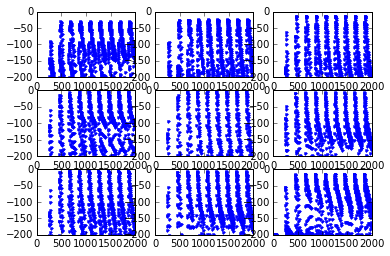

In [28]:
for si in range(nSub):
    plt.subplot(3,3,si+1)
    plt.plot(totLL[:,si],'.')
    plt.ylim(-200, 0)

In [29]:
# Find the parameters for which likelihood is maximum
# There are some NaN values in the likelihood matrix so exclude those
maxParId = np.zeros(nSub)

# Record the values of best fit x for each CD combination
bestx = np.zeros((nCD, nSub), dtype = np.int)

for si in range(nSub):
    maxParId[si] = np.where(totLL[:,si] == np.nanmax(totLL[:,si]))[0]
    bestx[:,si] = bestXcd[maxParId[si],:,si]
    # print(np.where(maxLLx[:,si] == np.nanmax(maxLLx[:,si]))[0])

In [30]:
for si in range(nSub):
    print(totLL[maxParId[si],si])

-29.8112028986
-23.7031065367
-12.482551193
-2.78054927391
0.439572271487
-3.86455899495
3.16998006183
-6.28349326915
-13.5193673715


In [33]:
subXs = np.zeros((nCD, nSub))
# Print the parameter values predicting maximum likelihoods
# for the different coherence-distance combinations
for si in range(nSub):
    print(round(As[maxParId[si]],ndigits=3), round(ks[maxParId[si]],ndigits=3), round(tRs[maxParId[si]],ndigits=3))
    # print(np.reshape(bestXcd[maxParId[si],:,si],(4,5)))
    print(x[bestXcd[maxParId[si],:,si]].round(decimals=2))
    subXs[:,si] = x[bestx[:,si]].round(decimals=2)
    
np.savetxt('SubXs_noZeroCD_posParam.csv', subXs, fmt = '%.2f', delimiter = ',')

(1.611, 0.452, 0.001)
[ 0.17  0.53  0.49  0.95  0.75  1.13  1.21  1.35  0.51  3.72  3.76  3.82]
(1.333, 0.894, 0.474)
[ 0.27  0.85  0.85  0.77  0.55  1.21  1.23  1.07  0.19  2.64  3.06  3.28]
(1.333, 0.673, 0.159)
[ 0.19  0.85  0.75  0.73  0.73  1.49  1.73  1.61  1.05  2.44  3.    2.96]
(1.056, 0.894, 0.474)
[ 0.13  0.69  0.91  0.89  0.63  1.55  1.61  1.93  0.37  2.38  3.68  3.54]
(1.056, 0.894, 0.369)
[ 0.39  0.89  1.05  1.15  0.61  1.61  1.53  1.69  1.09  2.84  3.12  3.94]
(1.056, 0.673, 0.422)
[ 0.65  0.73  0.93  0.97  0.31  0.99  1.21  1.25  1.13  2.2   3.02  3.  ]
(1.056, 1.116, 0.474)
[ 0.25  0.71  0.95  0.89  0.33  1.27  1.47  1.55  0.63  1.71  3.12  3.46]
(1.056, 0.673, 0.422)
[ 0.77  1.03  1.39  1.43  0.47  1.97  2.32  2.52  0.25  2.04  3.04  2.82]
(1.056, 0.673, 0.369)
[ 0.27  0.23  0.39  0.17  0.27  0.33  0.23  0.29  1.53  2.6   3.12  3.12]


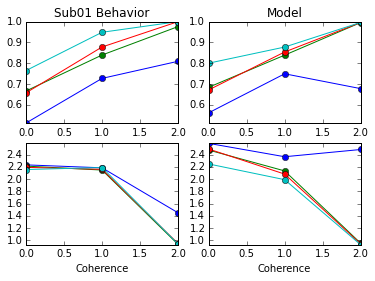

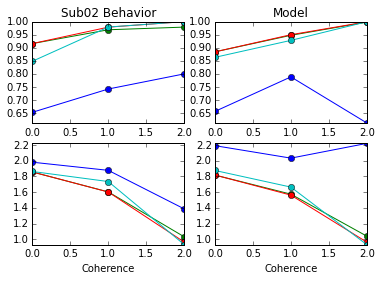

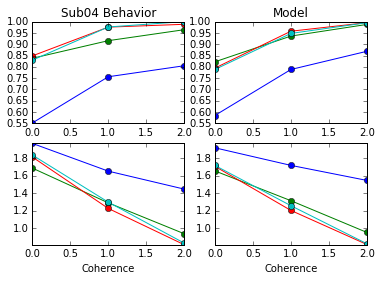

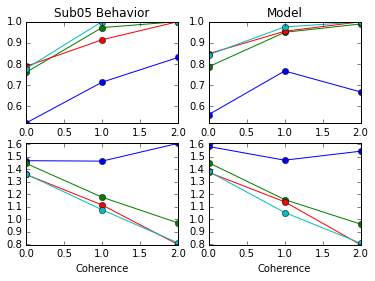

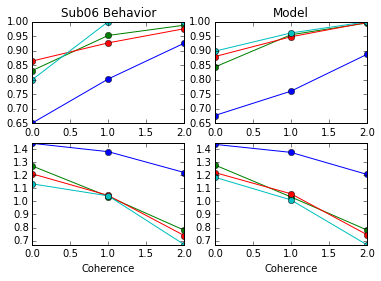

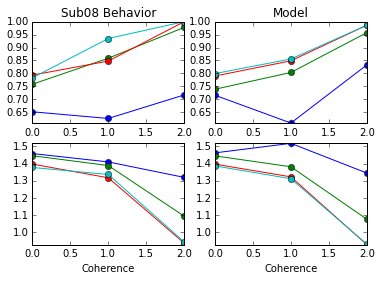

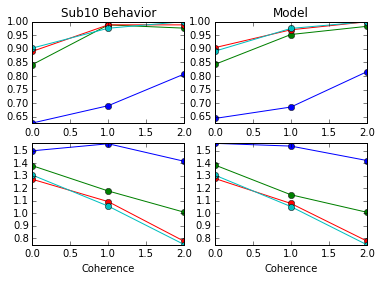

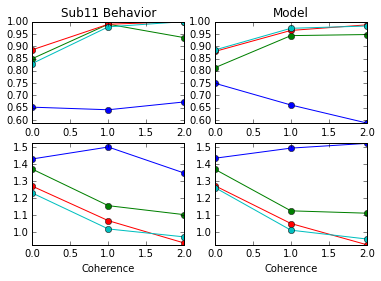

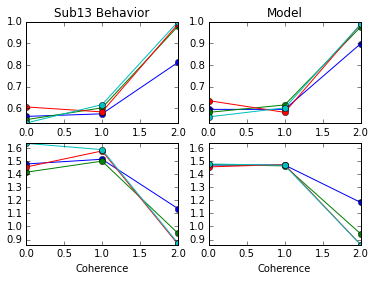

In [32]:
# Plot the observed (behavior) and expected (model) PC and RT
for si in range(nSub):
    temp = []
    ymin = min(pCs[:,si])
    ymax = max(pCs[:,si])
    for cdi in range(nCD):
        temp.append(epc[maxParId[si], bestx[cdi,si], cdi, si])
    if min(temp) < ymin:
        ymin = min(temp)
    if max(temp) > ymax:
        ymax = max(temp)
    
    plt.figure()
    plt.subplot(221)
    plt.title(subs[si] + ' Behavior')
    plt.plot(np.reshape(pCs[:,si],(3,4)),'o-')
    plt.ylim((ymin, ymax))
    
    plt.subplot(222)
    plt.title('Model')
    plt.plot(np.reshape(temp,(3,4)),'o-')
    plt.ylim((ymin,ymax))

    temp = []
    ymin = min(mRTs[:,si])
    ymax = max(mRTs[:,si])
    for cdi in range(nCD):
        temp.append(ert[maxParId[si], bestx[cdi,si], cdi, si])
    if min(temp) < ymin:
        ymin = min(temp)
    if max(temp) > ymax:
        ymax = max(temp)
    
    plt.subplot(223)
    plt.plot(np.reshape(mRTs[:,si],(3,4)),'o-')
    plt.ylim((ymin,ymax))
    plt.xlabel('Coherence')
    
    plt.subplot(224)
    plt.plot(np.reshape(temp,(3,4)),'o-')
    plt.ylim((ymin,ymax))
    plt.xlabel('Coherence')

In [ ]:
pCs.shape

In [34]:
minA = np.zeros(nSub)
maxA = np.zeros(nSub)
mink = np.zeros(nSub)
maxk = np.zeros(nSub)
mintR = np.zeros(nSub)
maxtR = np.zeros(nSub)

nd = 3 # Number of deltas before and after best fit value

for si in range(nSub):
    # Set up A, k and tR parameters for the next round of simulations
    # Use the bestx values from the first run, don't fit for x again
    
    # First set the range of all variables. 
    # minVar = bestValue - dVar*nd : bestValue + dVar*nd
    # If the new minimum is <= 0, then set it to the old minimum.
    minA[si] = As[maxParId[si]] - nd * dA
    maxA[si] = As[maxParId[si]] + nd * dA
    # if minA[si] < 0:
    #    minA[si] = A[0]
    
    mink[si] = ks[maxParId[si]] - nd * dk
    maxk[si] = ks[maxParId[si]] + nd * dk
    # if mink[si] < 0:
    #    mink[si] = k[0]
        
    mintR[si] = tRs[maxParId[si]] - nd * dtR
    maxtR[si] = tRs[maxParId[si]] + nd * dtR
    # if mintR[si] < 0:
    #    mintR[si] = tR[0]

In [35]:
print(minA.round(decimals=3))
print(maxA.round(decimals=3))
print(mink.round(decimals=3))
print(maxk.round(decimals=3))
print(mintR.round(decimals=3))
print(maxtR.round(decimals=3))

[ 0.778  0.5    0.5    0.222  0.222  0.222  0.222  0.222  0.222]
[ 2.444  2.167  2.167  1.889  1.889  1.889  1.889  1.889  1.889]
[-0.211  0.231  0.01   0.231  0.231  0.01   0.452  0.01   0.01 ]
[ 1.116  1.558  1.337  1.558  1.558  1.337  1.779  1.337  1.337]
[-0.157  0.316  0.001  0.316  0.211  0.264  0.316  0.264  0.211]
[ 0.159  0.632  0.316  0.632  0.527  0.579  0.632  0.579  0.527]


In [36]:
nStep = 9 # Number of values tested, per parameter

A = np.zeros((nStep, nSub))
dA = np.zeros(nSub)
k = np.zeros((nStep, nSub))
dk = np.zeros(nSub)
tR = np.zeros((nStep, nSub))
dtR = np.zeros(nSub)

# This is the overall number of permutations of A, k and tR being performed
nPar = nStep ** 3

As = np.zeros((nPar, nSub))
ks = np.zeros((nPar, nSub))
tRs = np.zeros((nPar, nSub))

for si in range(nSub):
    A[:,si], dA[si] = np.linspace(minA[si], maxA[si], nStep, retstep=True)
    k[:,si], dk[si] = np.linspace(mink[si], maxk[si], nStep, retstep=True)
    tR[:,si], dtR[si] = np.linspace(mintR[si], maxtR[si], nStep, retstep=True)

    tempAs, tempks, temptRs = np.meshgrid(A[:,si], k[:,si], tR[:,si])
    As[:,si] = tempAs.flatten()
    ks[:,si] = tempks.flatten()
    tRs[:,si] = temptRs.flatten()

    # Initialize arrays that hold predicted accuracies and RTs
    epc = np.ones((nPar, nCD, 9)) * -9
    ert = np.ones((nPar, nCD, 9)) * -9
    sdrt = np.ones((nPar, nCD, 9)) * -9

    ## Initialize the array that holds the
    # individual likelihood values
    lpc = np.zeros((nPar, nCD, 9))
    lrt = np.zeros((nPar, nCD, 9))
    # final likelihood values
    ll = np.ones((nPar, 9)) * -9

In [37]:
# From the set of parameters, calculate the (expected) predicted PC and RT
# and then find the likelihood that these estimates match the observed PC and RT
for si in range(nSub):
    for pi in xrange(nPar):
        for cdi in range(nCD):
            # Calculate expected accuracy for each coherence-distance combination
            epc[pi,cdi,si] = 1 / (1 + np.exp(-2 * As[pi,si] * ks[pi,si] * abs(x[bestx[cdi,si]])))

            # Calculate likelihood of accuracy for this CD combination
            lpc[pi,cdi,si] = fact(Ns[cdi,si]) / (fact(Rs[cdi,si]) * fact(Ns[cdi,si]-Rs[cdi,si])) * \
                                (epc[pi,cdi,si] ** Rs[cdi,si]) * \
                                ((1 - epc[pi,cdi,si]) ** (Ns[cdi,si] - Rs[cdi,si]))

            # Calculate expected mean RT for each coherence-distance combination
            ert[pi,cdi,si] = As[pi,si] / (ks[pi,si] * x[bestx[cdi,si]]) * \
                                np.tanh(As[pi,si] * ks[pi,si] * x[bestx[cdi,si]]) + tRs[pi,si] 
            # Calculate SD of mean RT 
            sdrt[pi,cdi,si] = np.sqrt(((As[pi,si] * np.tanh(As[pi,si] * ks[pi,si] * x[bestx[cdi,si]]) - \
                                As[pi,si] * ks[pi,si] * x[bestx[cdi,si]] * \
                                (1/np.cosh(np.square(As[pi,si] * ks[pi,si] * x[bestx[cdi,si]])))) / \
                                (ks[pi,si] * x[bestx[cdi,si]]) ** 3 + np.square(0.1 * tRs[pi,si])) / Ns[cdi,si])
            # Calculate likelihood of mean RT for this CD combination
            lrt[pi,cdi,si] = 1 / (sdrt[pi,cdi,si] * np.sqrt(2 * np.pi)) * \
                                np.e ** (-1/2 * np.square((ert[pi,cdi,si] - mRTs[cdi,si]) / sdrt[pi,cdi,si]))

In [38]:
#maxLLcd = np.ones((nPar, nCD, nSub)) * -9
totLL = np.zeros((nPar, nSub))

for si in range(nSub):
    for pi in range(nPar):
        # maxLLcd[pi,:,si] = np.argmax(lpc[pi,:,:,si]+lrt[pi,:,:,si],0)
        for cdi in range(nCD):
            totLL[pi,si] += np.log(lpc[pi,cdi,si]) + \
                                np.log(lrt[pi,cdi,si])

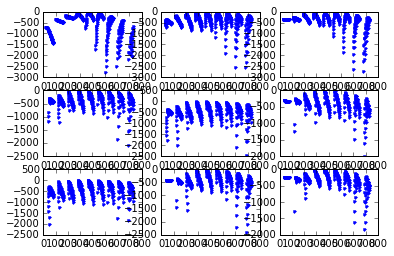

In [39]:
for si in range(nSub):
    plt.subplot(3,3,si+1)
    plt.plot(totLL[:,si],'.')

In [40]:
# Find the parameters for which likelihood is maximum
# There are some NaN values in the likelihood matrix so exclude those
maxParId = np.zeros(nSub)

for si in range(nSub):
    maxParId[si] = np.where(totLL[:,si] == np.nanmax(totLL[:,si]))[0]
    # print(np.where(maxLLx[:,si] == np.nanmax(maxLLx[:,si]))[0])

In [41]:
for si in range(nSub):
    print(totLL[maxParId[si],si])

-29.8112028986
-23.7031065367
-12.482551193
-2.78054927391
0.439572271487
-3.86455899495
3.16998006183
-6.28349326915
-13.5193673715


In [42]:
# Print the parameter values predicting maximum likelihoods
# for the different coherence-distance combinations
for si in range(nSub):
    print(round(As[maxParId[si],si],ndigits=3), round(ks[maxParId[si],si],ndigits=3), \
          round(tRs[maxParId[si],si],ndigits=3))
    # print(np.reshape(maxLLcd[maxParId[si],:,si],(4,5)))

(1.611, 0.452, 0.001)
(1.333, 0.894, 0.474)
(1.333, 0.673, 0.159)
(1.056, 0.894, 0.474)
(1.056, 0.894, 0.369)
(1.056, 0.673, 0.422)
(1.056, 1.116, 0.474)
(1.056, 0.673, 0.422)
(1.056, 0.673, 0.369)


In [ ]:
print(pCs[:,0])
print(pCs[:,0].reshape(4,5))
print(pCs[4:,0])
print(pCs[4:,0].reshape(4,4))

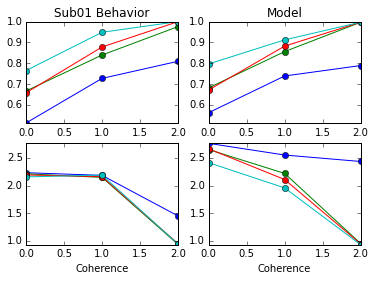

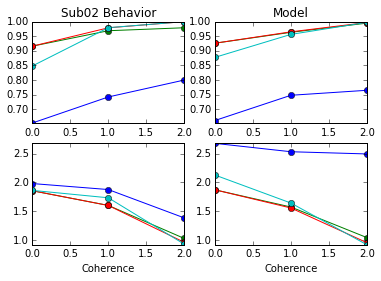

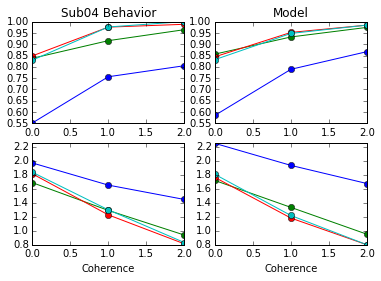

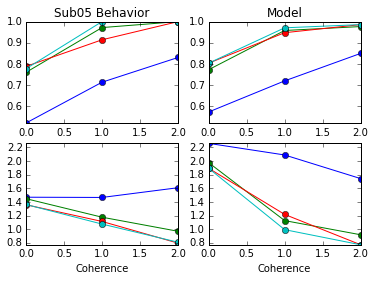

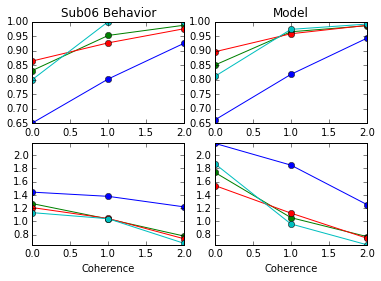

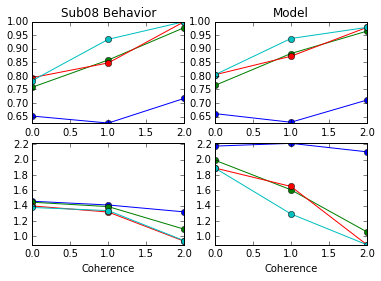

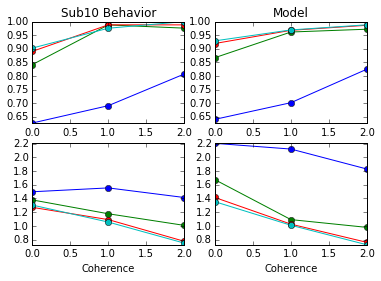

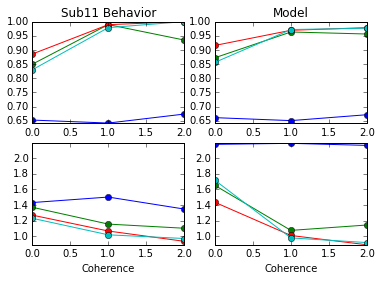

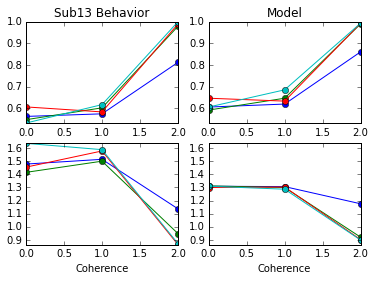

In [20]:
# Plot the observed (behavior) and expected (model) PC and RT
for si in range(nSub):
    temp = []
    ymin = min(pCs[:,si])
    ymax = max(pCs[:,si])
    for cdi in range(nCD):
        temp.append(epc[maxParId[si],cdi,si])
    if min(temp) < ymin:
        ymin = min(temp)
    if max(temp) > ymax:
        ymax = max(temp)
    
    plt.figure()
    plt.subplot(221)
    plt.title(subs[si] + ' Behavior')
    plt.plot(np.reshape(pCs[:,si],(3,4)),'o-')
    plt.ylim((ymin, ymax))
    
    plt.subplot(222)
    plt.title('Model')
    plt.plot(np.reshape(temp,(3,4)),'o-')
    plt.ylim((ymin,ymax))

    temp = []
    ymin = min(mRTs[:,si])
    ymax = max(mRTs[:,si])
    for cdi in range(nCD):
        temp.append(ert[maxParId[si],cdi,si])
    if min(temp) < ymin:
        ymin = min(temp)
    if max(temp) > ymax:
        ymax = max(temp)
    
    plt.subplot(223)
    plt.plot(np.reshape(mRTs[:,si],(3,4)),'o-')
    plt.ylim((ymin,ymax))
    plt.xlabel('Coherence')
    
    plt.subplot(224)
    plt.plot(np.reshape(temp,(3,4)),'o-')
    plt.ylim((ymin,ymax))
    plt.xlabel('Coherence')

[-3.542 -3.542 -0.208 -3.542 -3.542 -3.542 -3.542 -3.542 -2.708]
[ 0.208  0.208  3.542  0.208  0.208  0.208  0.208  0.208  1.042]
[-2.431 -2.431 -1.319 -2.431 -2.431 -2.431 -2.431 -2.431 -3.264]
[ 1.319  1.319  2.431  1.319  1.319  1.319  1.319  1.319  0.486]
[-0.844 -0.844 -1.344 -1.344 -1.344 -1.344 -1.344 -1.344 -0.219]
[ 0.844  0.844  0.344  0.344  0.344  0.344  0.344  0.344  1.469]
-28.697
-19.424
-18.475
-23.967
-21.546
-30.83
-19.423
-25.802
-28.712
(-1.667, -0.556, 0.0)
(-1.667, -0.556, 0.0)
(1.667, 0.556, -0.5)
(-1.667, -0.556, -0.5)
(-1.667, -0.556, -0.5)
(-1.667, -0.556, -0.5)
(-1.667, -0.556, -0.5)
(-1.667, -0.556, -0.5)
(-0.833, -1.389, 0.625)


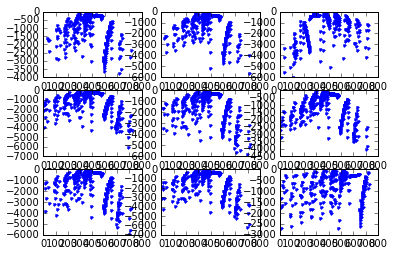

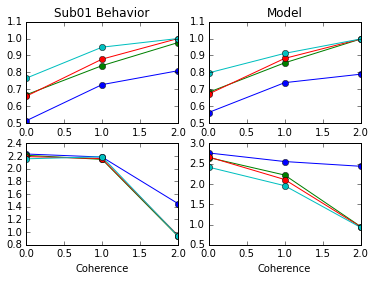

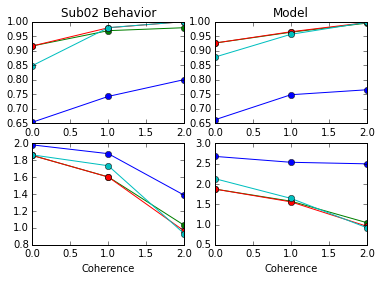

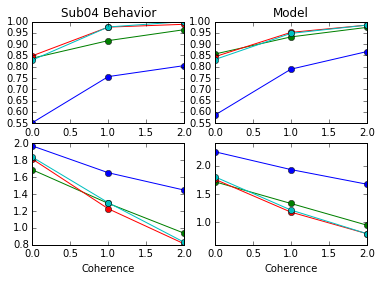

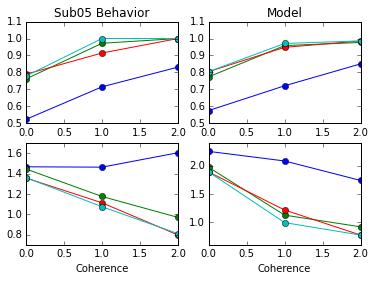

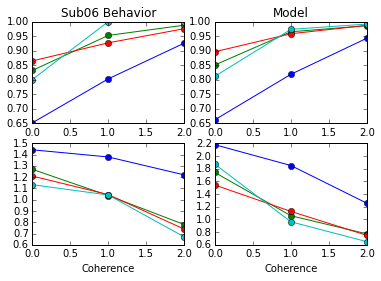

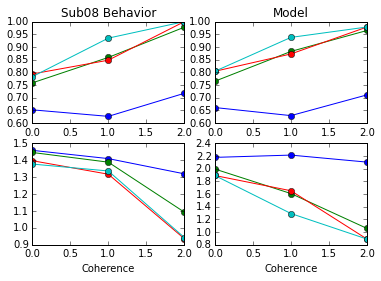

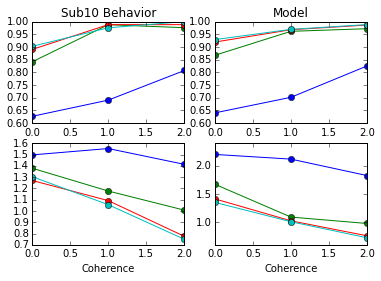

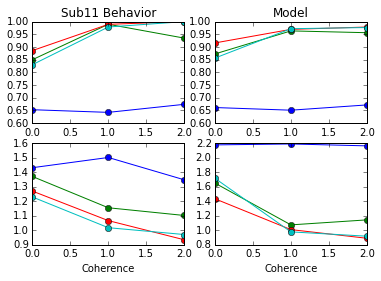

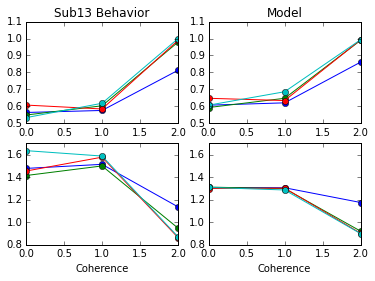

In [22]:
minA = np.zeros(nSub)
maxA = np.zeros(nSub)
mink = np.zeros(nSub)
maxk = np.zeros(nSub)
mintR = np.zeros(nSub)
maxtR = np.zeros(nSub)

for si in range(nSub):
    # Set up A, k and tR parameters for the next round of simulations
    # Use the bestx values from the first run, don't fit for x again
    
    # First set the range of all variables. 
    # minVar = bestValue - dVar*nd : bestValue + dVar*nd
    # If the new minimum is <= 0, then set it to the old minimum.
    minA[si] = As[maxParId[si],si] - nd * dA[si]
    maxA[si] = As[maxParId[si],si] + nd * dA[si]
    # if minA[si] < 0:
    #    minA[si] = A[0,si]
    
    mink[si] = ks[maxParId[si],si] - nd * dk[si]
    maxk[si] = ks[maxParId[si],si] + nd * dk[si]
    # if mink[si] < 0:
    #    mink[si] = k[0,si]
        
    mintR[si] = tRs[maxParId[si],si] - nd * dtR[si]
    maxtR[si] = tRs[maxParId[si],si] + nd * dtR[si]
    # if mintR[si] < 0:
    #    mintR[si] = tR[0,si]
        
print(minA.round(decimals=3))
print(maxA.round(decimals=3))
print(mink.round(decimals=3))
print(maxk.round(decimals=3))
print(mintR.round(decimals=3))
print(maxtR.round(decimals=3))

A = np.zeros((nStep, nSub))
dA = np.zeros(nSub)
k = np.zeros((nStep, nSub))
dk = np.zeros(nSub)
tR = np.zeros((nStep, nSub))
dtR = np.zeros(nSub)

As = np.zeros((nPar, nSub))
ks = np.zeros((nPar, nSub))
tRs = np.zeros((nPar, nSub))

for si in range(nSub):
    A[:,si], dA[si] = np.linspace(minA[si], maxA[si], nStep, retstep=True)
    k[:,si], dk[si] = np.linspace(mink[si], maxk[si], nStep, retstep=True)
    tR[:,si], dtR[si] = np.linspace(mintR[si], maxtR[si], nStep, retstep=True)

    tempAs, tempks, temptRs = np.meshgrid(A[:,si], k[:,si], tR[:,si])
    As[:,si] = tempAs.flatten()
    ks[:,si] = tempks.flatten()
    tRs[:,si] = temptRs.flatten()

    # This is the overall number of permutations of A, k and tR being performed
    nPar = len(A) * len(k) * len(tR)
    
    # Initialize arrays that hold predicted accuracies and RTs
    epc = np.ones((nPar, nCD, 9)) * -9
    ert = np.ones((nPar, nCD, 9)) * -9
    sdrt = np.ones((nPar, nCD, 9)) * -9

    ## Initialize the array that holds the
    # individual likelihood values
    lpc = np.zeros((nPar, nCD, 9))
    lrt = np.zeros((nPar, nCD, 9))
    # final likelihood values
    ll = np.ones((nPar, 9)) * -9
    
# From the set of parameters, calculate the (expected) predicted PC and RT
# and then find the likelihood that these estimates match the observed PC and RT
for si in range(nSub):
    for pi in xrange(nPar):
        for cdi in range(nCD):
            # Calculate expected accuracy for each coherence-distance combination
            epc[pi,cdi,si] = 1 / (1 + np.exp(-2 * As[pi,si] * ks[pi,si] * abs(x[bestx[cdi,si]])))

            # Calculate likelihood of accuracy for this CD combination
            lpc[pi,cdi,si] = fact(Ns[cdi,si]) / (fact(Rs[cdi,si]) * fact(Ns[cdi,si]-Rs[cdi,si])) * \
                                (epc[pi,cdi,si] ** Rs[cdi,si]) * \
                                ((1 - epc[pi,cdi,si]) ** (Ns[cdi,si] - Rs[cdi,si]))

            # Calculate expected mean RT for each coherence-distance combination
            ert[pi,cdi,si] = As[pi,si] / (ks[pi,si] * x[bestx[cdi,si]]) * \
                                np.tanh(As[pi,si] * ks[pi,si] * x[bestx[cdi,si]]) + tRs[pi,si] 
            # Calculate SD of mean RT 
            sdrt[pi,cdi,si] = np.sqrt(((As[pi,si] * np.tanh(As[pi,si] * ks[pi,si] * x[bestx[cdi,si]]) - \
                    As[pi,si] * ks[pi,si] * x[bestx[cdi,si]] * \
                    (1/np.cosh(np.square(As[pi,si] * ks[pi,si] * x[bestx[cdi,si]])))) / \
                    (ks[pi,si] * x[bestx[cdi,si]]) ** 3 + np.square(0.1 * tRs[pi,si])) / Ns[cdi,si])
            # Calculate likelihood of mean RT for this CD combination
            lrt[pi,cdi,si] = 1 / (sdrt[pi,cdi,si] * np.sqrt(2 * np.pi)) * \
                                np.e ** (-1/2 * np.square((ert[pi,cdi,si] - mRTs[cdi,si]) / sdrt[pi,cdi,si]))
                
#maxLLcd = np.ones((nPar, nCD, nSub)) * -9
totLL = np.zeros((nPar, nSub))

for si in range(nSub):
    for pi in range(nPar):
        # maxLLcd[pi,:,si] = np.argmax(lpc[pi,:,:,si]+lrt[pi,:,:,si],0)
        for cdi in range(nCD):
            totLL[pi,si] += np.log(lpc[pi,cdi,si]) + \
                                np.log(lrt[pi,cdi,si])
                
for si in range(nSub):
    plt.subplot(3,3,si+1)
    plt.plot(totLL[:,si],'.')
    
# Find the parameters for which likelihood is maximum
# There are some NaN values in the likelihood matrix so exclude those
maxParId = np.zeros(nSub)

for si in range(nSub):
    maxParId[si] = np.where(totLL[:,si] == np.nanmax(totLL[:,si]))[0]
    # print(np.where(maxLLx[:,si] == np.nanmax(maxLLx[:,si]))[0])
    
for si in range(nSub):
    print(round(totLL[maxParId[si],si],ndigits=3))
    
# Print the parameter values predicting maximum likelihoods
# for the different coherence-distance combinations
for si in range(nSub):
    print(round(As[maxParId[si],si],ndigits=3), round(ks[maxParId[si],si],ndigits=3), \
          round(tRs[maxParId[si],si],ndigits=3))
    # print(np.reshape(maxLLcd[maxParId[si],:,si],(4,5)))
    
# Plot the observed (behavior) and expected (model) PC and RT
for si in range(nSub):
    temp = []
    ymin = min(pCs[:,si])
    ymax = max(pCs[:,si])
    for cdi in range(nCD):
        temp.append(epc[maxParId[si],cdi,si])
    if min(temp) < ymin:
        ymin = min(temp)
    if max(temp) > ymax:
        ymax = max(temp)
    
    plt.figure()
    plt.subplot(221)
    plt.title(subs[si] + ' Behavior')
    plt.plot(np.reshape(pCs[:,si],(3,4)),'o-')
    plt.ylim((ymin, ymax))
    
    plt.subplot(222)
    plt.title('Model')
    plt.plot(np.reshape(temp,(3,4)),'o-')
    plt.ylim((ymin,ymax))

    temp = []
    ymin = min(mRTs[:,si])
    ymax = max(mRTs[:,si])
    for cdi in range(nCD):
        temp.append(ert[maxParId[si],cdi,si])
    if min(temp) < ymin:
        ymin = min(temp)
    if max(temp) > ymax:
        ymax = max(temp)
    
    plt.subplot(223)
    plt.plot(np.reshape(mRTs[:,si],(3,4)),'o-')
    plt.ylim((ymin,ymax))
    plt.xlabel('Coherence')
    
    plt.subplot(224)
    plt.plot(np.reshape(temp,(3,4)),'o-')
    plt.ylim((ymin,ymax))
    plt.xlabel('Coherence')

In [ ]:
minA = np.zeros(nSub)
maxA = np.zeros(nSub)
mink = np.zeros(nSub)
maxk = np.zeros(nSub)
mintR = np.zeros(nSub)
maxtR = np.zeros(nSub)

nd = 4 # Number of deltas before and after best fit value

for si in range(nSub):
    # Set up A, k and tR parameters for the next round of simulations
    # Use the bestx values from the first run, don't fit for x again
    
    # First set the range of all variables. 
    # minVar = bestValue - dVar*nd : bestValue + dVar*nd
    # If the new minimum is <= 0, then set it to the old minimum.
    minA[si] = As[maxParId[si],si] - nd * dA[si]
    maxA[si] = As[maxParId[si],si] + nd * dA[si]
    if minA[si] < 0:
        minA[si] = A[0,si]
    
    mink[si] = ks[maxParId[si],si] - nd * dk[si]
    maxk[si] = ks[maxParId[si],si] + nd * dk[si]
    if mink[si] < 0:
        mink[si] = k[0,si]
        
    mintR[si] = tRs[maxParId[si],si] - nd * dtR[si]
    maxtR[si] = tRs[maxParId[si],si] + nd * dtR[si]
    if mintR[si] < 0:
        mintR[si] = tR[0,si]
        
A = np.zeros((10, nSub))
dA = np.zeros(nSub)
k = np.zeros((10, nSub))
dk = np.zeros(nSub)
tR = np.zeros((10, nSub))
dtR = np.zeros(nSub)

As = np.zeros((1000, nSub))
ks = np.zeros((1000, nSub))
tRs = np.zeros((1000, nSub))

nStep = 10 # Number of values tested, per parameter

for si in range(nSub):
    A[:,si], dA[si] = np.linspace(minA[si], maxA[si], nStep, retstep=True)
    k[:,si], dk[si] = np.linspace(mink[si], maxk[si], nStep, retstep=True)
    tR[:,si], dtR[si] = np.linspace(mintR[si], maxtR[si], nStep, retstep=True)

    tempAs, tempks, temptRs = np.meshgrid(A[:,si], k[:,si], tR[:,si])
    As[:,si] = tempAs.flatten()
    ks[:,si] = tempks.flatten()
    tRs[:,si] = temptRs.flatten()

    # This is the overall number of permutations of A, k and tR being performed
    nPar = len(A) * len(k) * len(tR)
    
    # Initialize arrays that hold predicted accuracies and RTs
    epc = np.ones((nPar, nCD, 9)) * -9
    ert = np.ones((nPar, nCD, 9)) * -9
    sdrt = np.ones((nPar, nCD, 9)) * -9

    ## Initialize the array that holds the
    # individual likelihood values
    lpc = np.zeros((nPar, nCD, 9))
    lrt = np.zeros((nPar, nCD, 9))
    # final likelihood values
    ll = np.ones((nPar, 9)) * -9
    
# From the set of parameters, calculate the (expected) predicted PC and RT
# and then find the likelihood that these estimates match the observed PC and RT
for si in range(nSub):
    for pi in xrange(nPar):
        for cdi in range(nCD):
            # Calculate expected accuracy for each coherence-distance combination
            epc[pi,cdi,si] = 1 / (1 + np.exp(-2 * As[pi,si] * ks[pi,si] * abs(x[bestx[cdi,si]])))

            # Calculate likelihood of accuracy for this CD combination
            lpc[pi,cdi,si] = fact(Ns[cdi,si]) / (fact(Rs[cdi,si]) * fact(Ns[cdi,si]-Rs[cdi,si])) * \
                                (epc[pi,cdi,si] ** Rs[cdi,si]) * \
                                ((1 - epc[pi,cdi,si]) ** (Ns[cdi,si] - Rs[cdi,si]))

            # Calculate expected mean RT for each coherence-distance combination
            ert[pi,cdi,si] = As[pi,si] / (ks[pi,si] * x[bestx[cdi,si]]) * \
                                np.tanh(As[pi,si] * ks[pi,si] * x[bestx[cdi,si]]) + tRs[pi,si] 
            # Calculate SD of mean RT 
            sdrt[pi,cdi,si] = np.sqrt(((As[pi,si] * np.tanh(As[pi,si] * ks[pi,si] * x[bestx[cdi,si]]) - \
                    As[pi,si] * ks[pi,si] * x[bestx[cdi,si]] * \
                    (1/np.cosh(np.square(As[pi,si] * ks[pi,si] * x[bestx[cdi,si]])))) / \
                    (ks[pi,si] * x[bestx[cdi,si]]) ** 3 + np.square(0.1 * tRs[pi,si])) / Ns[cdi,si])
            # Calculate likelihood of mean RT for this CD combination
            lrt[pi,cdi,si] = 1 / (sdrt[pi,cdi,si] * np.sqrt(2 * np.pi)) * \
                                np.e ** (-1/2 * np.square((ert[pi,cdi,si] - mRTs[cdi,si]) / sdrt[pi,cdi,si]))
                
#maxLLcd = np.ones((nPar, nCD, nSub)) * -9
totLL = np.zeros((nPar, nSub))

for si in range(nSub):
    for pi in range(nPar):
        # maxLLcd[pi,:,si] = np.argmax(lpc[pi,:,:,si]+lrt[pi,:,:,si],0)
        for cdi in range(nCD):
            totLL[pi,si] += np.log(lpc[pi,cdi,si]) + \
                                np.log(lrt[pi,cdi,si])
                
for si in range(nSub):
    plt.subplot(3,3,si+1)
    plt.plot(totLL[:,si],'.')
    
# Find the parameters for which likelihood is maximum
# There are some NaN values in the likelihood matrix so exclude those
maxParId = np.zeros(nSub)

for si in range(nSub):
    maxParId[si] = np.where(totLL[:,si] == np.nanmax(totLL[:,si]))[0]
    # print(np.where(maxLLx[:,si] == np.nanmax(maxLLx[:,si]))[0])
    
for si in range(nSub):
    print(totLL[maxParId[si],si])
    
# Print the parameter values predicting maximum likelihoods
# for the different coherence-distance combinations
for si in range(nSub):
    print(As[maxParId[si],si].round(decimals=3), ks[maxParId[si],si].round(decimals=3), \
          tRs[maxParId[si],si].round(decimals=3))
    # print(np.reshape(maxLLcd[maxParId[si],:,si],(4,5)))
    
# Plot the observed (behavior) and expected (model) PC and RT
for si in range(nSub):
    temp = []
    ymin = min(pCs[:,si])
    ymax = max(pCs[:,si])
    for cdi in range(nCD):
        temp.append(epc[maxParId[si],cdi,si])
    if min(temp) < ymin:
        ymin = min(temp)
    if max(temp) > ymax:
        ymax = max(temp)
    
    plt.figure()
    plt.subplot(221)
    plt.title(subs[si] + ' Behavior')
    plt.plot(np.reshape(pCs[:,si],(3,4)),'o-')
    plt.ylim((ymin, ymax))
    
    plt.subplot(222)
    plt.title('Model')
    plt.plot(np.reshape(temp,(3,4)),'o-')
    plt.ylim((ymin,ymax))

    temp = []
    ymin = min(mRTs[:,si])
    ymax = max(mRTs[:,si])
    for cdi in range(nCD):
        temp.append(ert[maxParId[si],cdi,si])
    if min(temp) < ymin:
        ymin = min(temp)
    if max(temp) > ymax:
        ymax = max(temp)
    
    plt.subplot(223)
    plt.plot(np.reshape(mRTs[:,si],(3,4)),'o-')
    plt.ylim((ymin,ymax))
    plt.xlabel('Coherence')
    
    plt.subplot(224)
    plt.plot(np.reshape(temp,(3,4)),'o-')
    plt.ylim((ymin,ymax))
    plt.xlabel('Coherence')